In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf


In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib
data_dir = 'brain-tumor-detection'
data_dir = pathlib.Path(data_dir).with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3000


In [4]:
batch_size = 32
img_height = 180
img_width = 180


In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 597ms/step - accuracy: 0.6630 - loss: 0.6579 - val_accuracy: 0.8117 - val_loss: 0.4178
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 432ms/step - accuracy: 0.7835 - loss: 0.4572 - val_accuracy: 0.8483 - val_loss: 0.3474
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 397ms/step - accuracy: 0.8276 - loss: 0.3918 - val_accuracy: 0.8817 - val_loss: 0.3120
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 382ms/step - accuracy: 0.8443 - loss: 0.3577 - val_accuracy: 0.8700 - val_loss: 0.3477
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 392ms/step - accuracy: 0.8492 - loss: 0.3352 - val_accuracy: 0.8983 - val_loss: 0.2889
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 388ms/step - accuracy: 0.8729 - loss: 0.2975 - val_accuracy: 0.7883 - val_loss: 0.5902
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 383ms/step - accuracy: 0.8539 - loss: 0.3349 - val_accuracy: 0.8783 - val_loss: 0.3013
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 382ms/step - accuracy: 0.8954 - loss: 0.2651 - val_accu

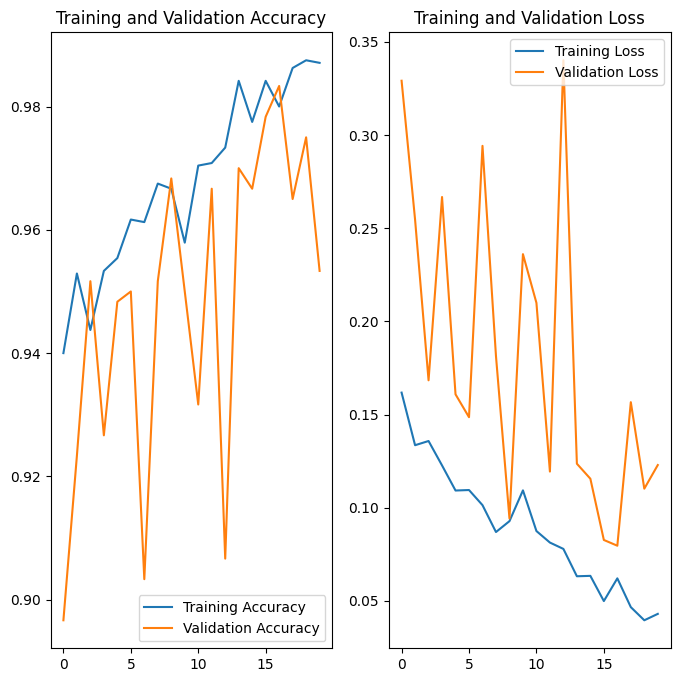

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import time
t = time.time()

export_path = "saved_models/yes-no.keras"
model.save(export_path)

export_path

'tmp/saved_models/yes-no.keras'

In [21]:
import random
reloaded = tf.keras.models.load_model(export_path)
#test on a random image
val_loss, val_accuracy = reloaded.evaluate(val_ds)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9565 - loss: 0.1241
Validation Loss: 0.14882005751132965, Validation Accuracy: 0.9549999833106995


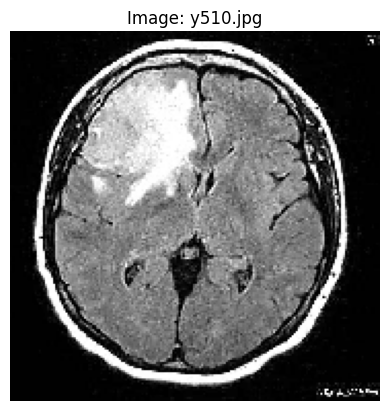

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: y510.jpg, Predicted Class: yes


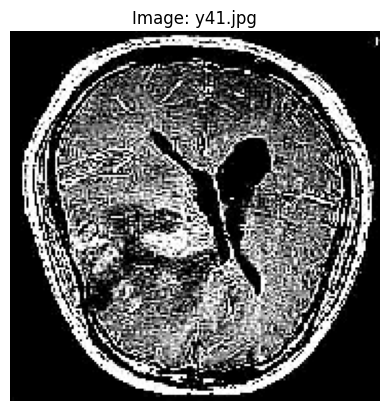

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: y41.jpg, Predicted Class: yes


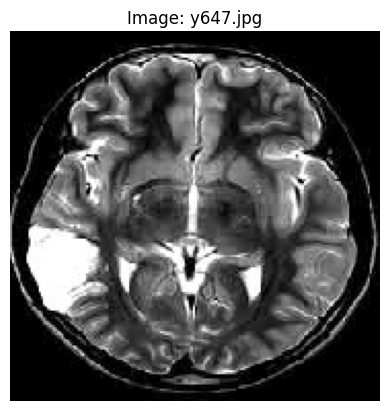

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: y647.jpg, Predicted Class: yes


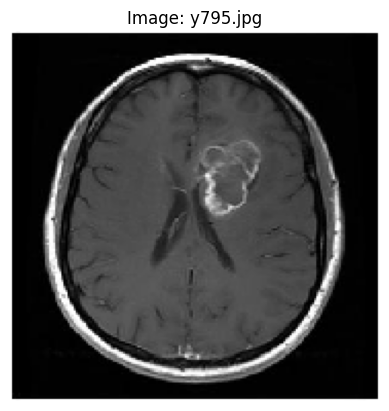

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: y795.jpg, Predicted Class: yes


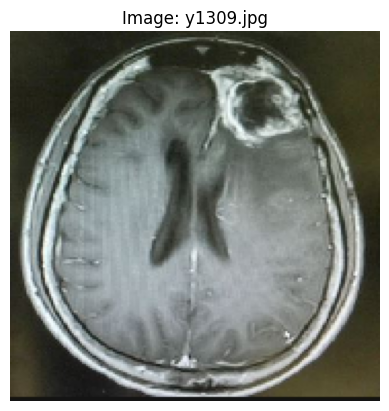

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: y1309.jpg, Predicted Class: yes


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

# Directory containing the images
yes_dir = os.path.join(data_dir, "yes")

# Get a list of all image file paths in the "yes" directory
image_paths = list(pathlib.Path(yes_dir).glob("*.jpg"))

# Select a random subset of images
random_images = random.sample(image_paths, 5)  # Change 5 to the desired number of random images

# Predict the class for each random image
for image_path in random_images:
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension

    # Display the image
    plt.figure()
    plt.imshow(img)
    plt.title(f"Image: {image_path.name}")
    plt.axis("off")
    plt.show()

    # Predict the class
    predictions = reloaded.predict(img_array)
    predicted_class = class_names[tf.argmax(predictions[0]).numpy()]

    # Print the result
    print(f"Image: {image_path.name}, Predicted Class: {predicted_class}")